Simulation scenario #5 (Index 6.1 from the simulation_scenarios document)

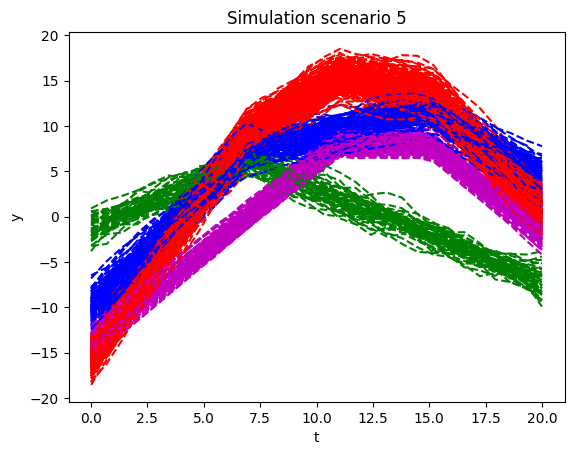

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import spatial, interpolate
from ensemble_clustering import functional_data_decomposition, functional_data_clustering
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from fda_results import percentage_variation_ami_ari, plot_percentage_variation_ami_ari

# Ignore convergence warnings
import warnings
warnings.filterwarnings("ignore")

# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

# Sample from the Gaussian process distribution
nb_of_samples = 30  # Number of points in each function
# Independent variable samples
t = np.expand_dims(np.linspace(0, 20, nb_of_samples), 1)
Σ = exponentiated_quadratic(t/0.5, t/12)  # Kernel of data points
Σ2 = exponentiated_quadratic(t, t/12)  # Kernel of data points
Σ3 = exponentiated_quadratic(t, t*2/3)  # Kernel of data points

# Declare the mean curve
mean_curve = np.zeros((3, len(t)))
# Mean curve with white noise
mean_curve[0] = np.reshape(6 - np.abs(t - 11), (nb_of_samples))
mean_curve[1] = np.reshape(6 - np.abs(t - 7), (nb_of_samples))
mean_curve[2] = np.reshape(6 - np.abs(t - 15), (nb_of_samples))


mixture_k = [0.2, 0.5, 0.1, 0.4	]
n = 500
Y = np.zeros((n, len(t)))
simulation_label = np.zeros(n)

for i in range(n):
    # generate a random number between 0 and 1
    r = np.random.rand()
    # find the index of the mixture component
    if r < mixture_k[0]:
        # draw for the first component
        ys = np.reshape(t/2, (nb_of_samples)) + np.random.multivariate_normal(mean=mean_curve[2], cov=Σ2, size=1) + np.random.multivariate_normal(mean=mean_curve[1], cov=Σ3, size=1) + np.random.normal(0, 0.08, len(t))*np.sqrt(0.1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='b')
        # Remember the label of the component
        simulation_label[i] = 0
    elif r < mixture_k[0] + mixture_k[1]:
        # draw for the first component
        ys = np.reshape(t/2, (nb_of_samples)) + np.random.multivariate_normal(mean=mean_curve[0], cov=Σ, size=1) + np.random.multivariate_normal(mean=mean_curve[1], cov=Σ2, size=1) + np.random.multivariate_normal(mean=mean_curve[2], cov=Σ3, size=1) + np.random.normal(0, 0.08, len(t))*np.sqrt(0.5)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='r')
        # Remember the label of the component
        simulation_label[i] = 1
    elif r < mixture_k[0] + mixture_k[1] + mixture_k[2]:
        # draw for the first component
        ys = np.random.multivariate_normal(mean=mean_curve[1], cov=Σ3, size=1)+ np.random.normal(0, 0.08, len(t))*np.sqrt(10)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='g')
        # Remember the label of the component
        simulation_label[i] = 2
    else:
        # draw for the first component
        ys = np.random.multivariate_normal(mean=mean_curve[0], cov=Σ, size=1) + np.random.multivariate_normal(mean=mean_curve[2], cov=Σ, size=1) + np.random.normal(0, 0.08, len(t))*np.sqrt(0.5)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='m')
        # Remember the label of the component
        simulation_label[i] = 3

plt.title('Simulation scenario 5')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

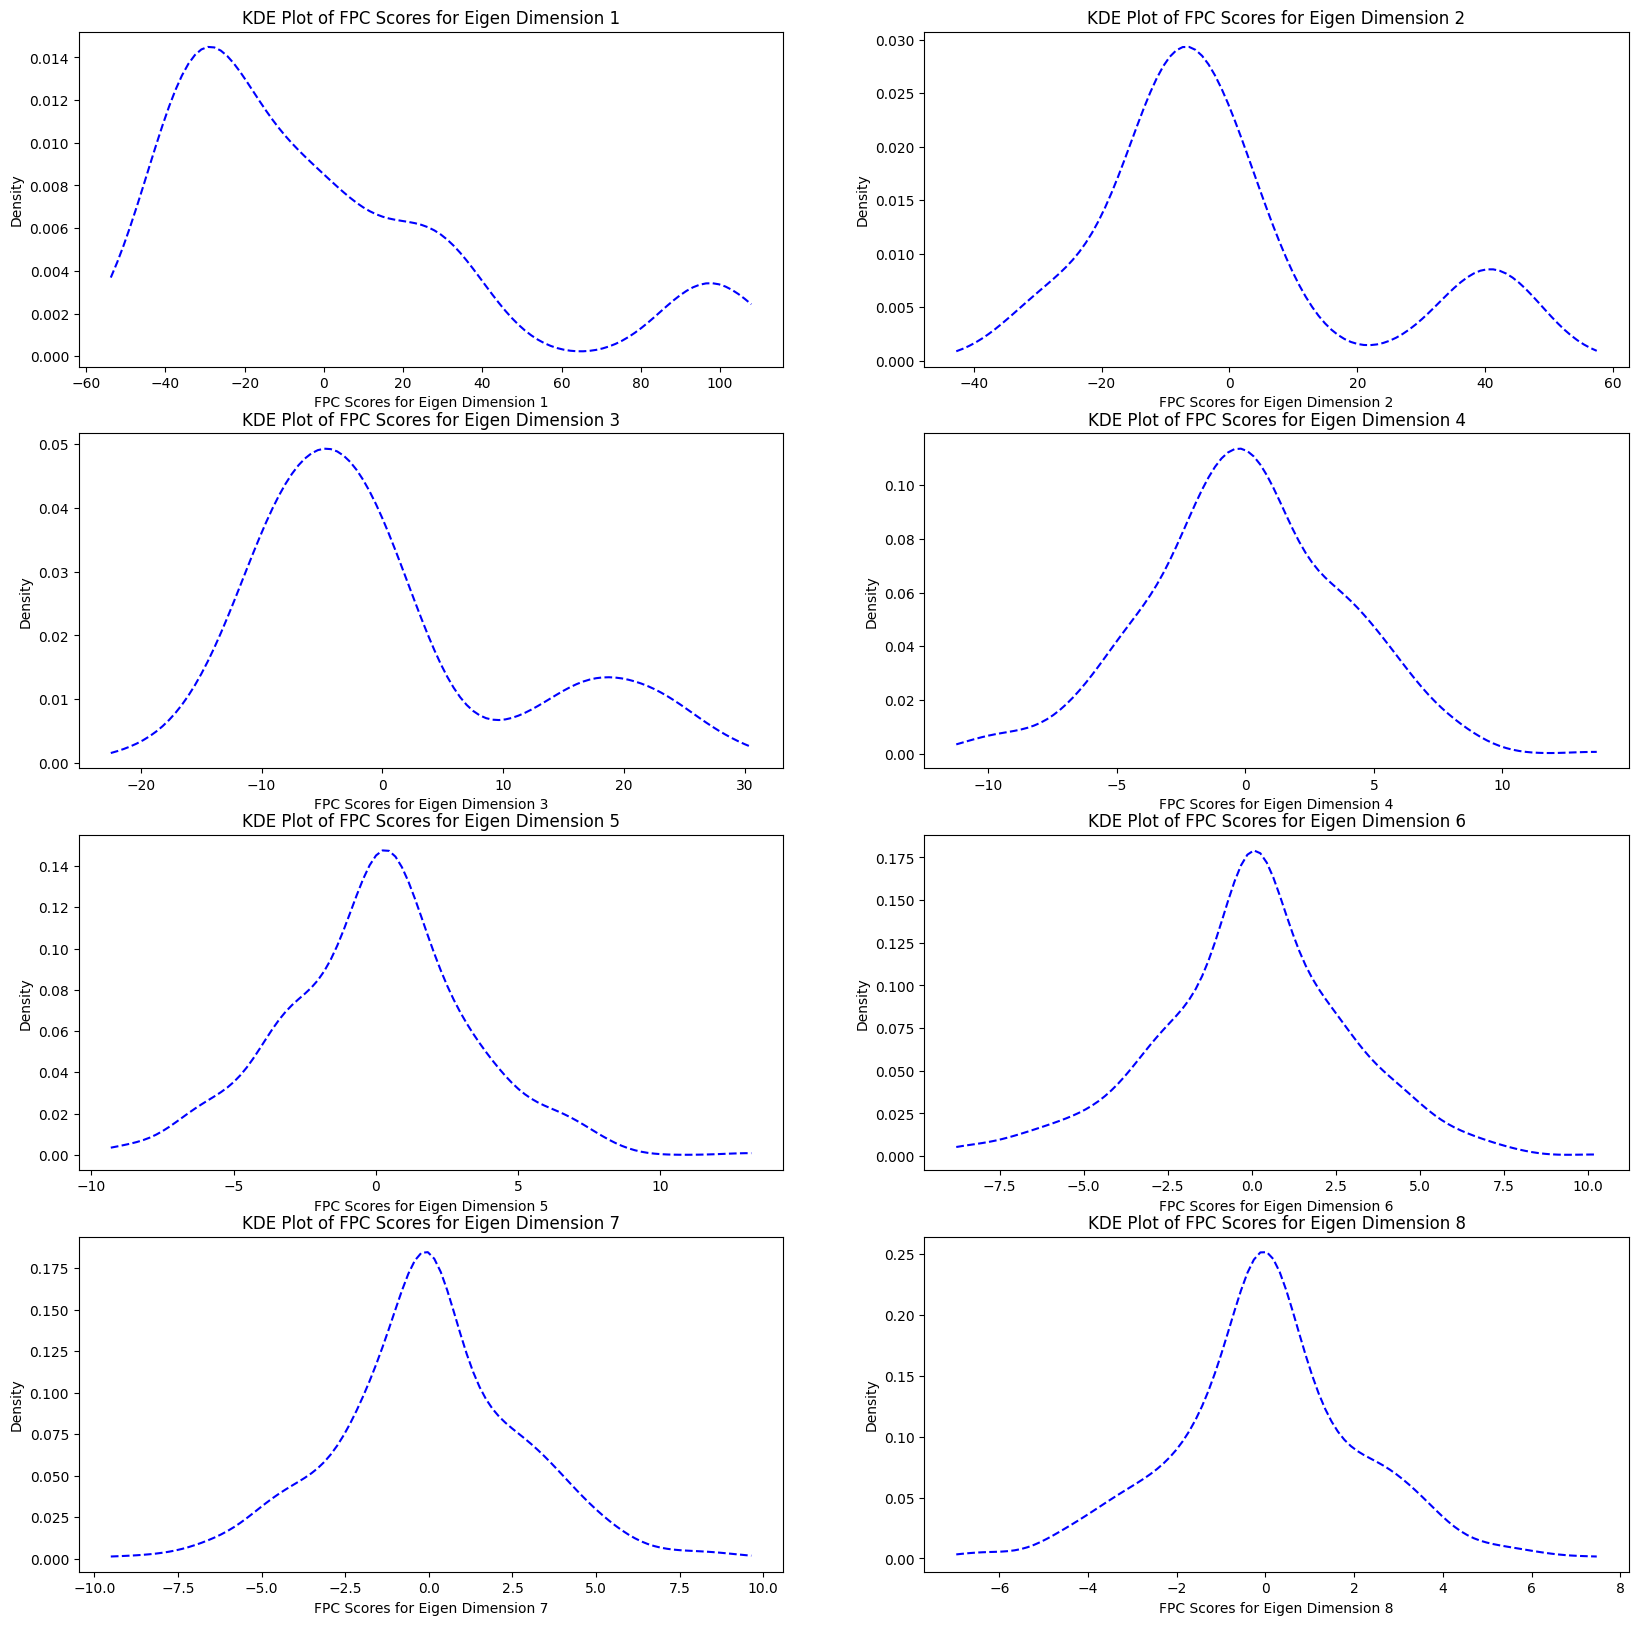

In [112]:
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (Y, 10, 150)

# For loop to plot a 2x2 set of scatter plots for the kernel density plots of the first four principal components
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for i in range(8):
    # Kernel density plot for principal components[i], as a scatter plot
    # Determine the desnity of principal components[i]
    kde = scipy.stats.gaussian_kde(principal_componenets[:,i])
    # Create a grid of points
    x_grid = np.linspace(min(principal_componenets[:,i]), max(principal_componenets[:,i]), 100)
    # Evaluate the density on the grid
    density = kde(x_grid)
    # Plot the density
    ax[i//2, i%2].plot(x_grid, density, color='b', linestyle='--')
    ax[i//2, i%2].set_title('KDE Plot of FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_xlabel('FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_ylabel('Density')
plt.show()

Percentage of variation explained by each eigen dimensions:  [0.73091219 0.19220094 0.05499547 0.00629297 0.004512   0.00361494
 0.00333482 0.00193303 0.00128829 0.00091534]


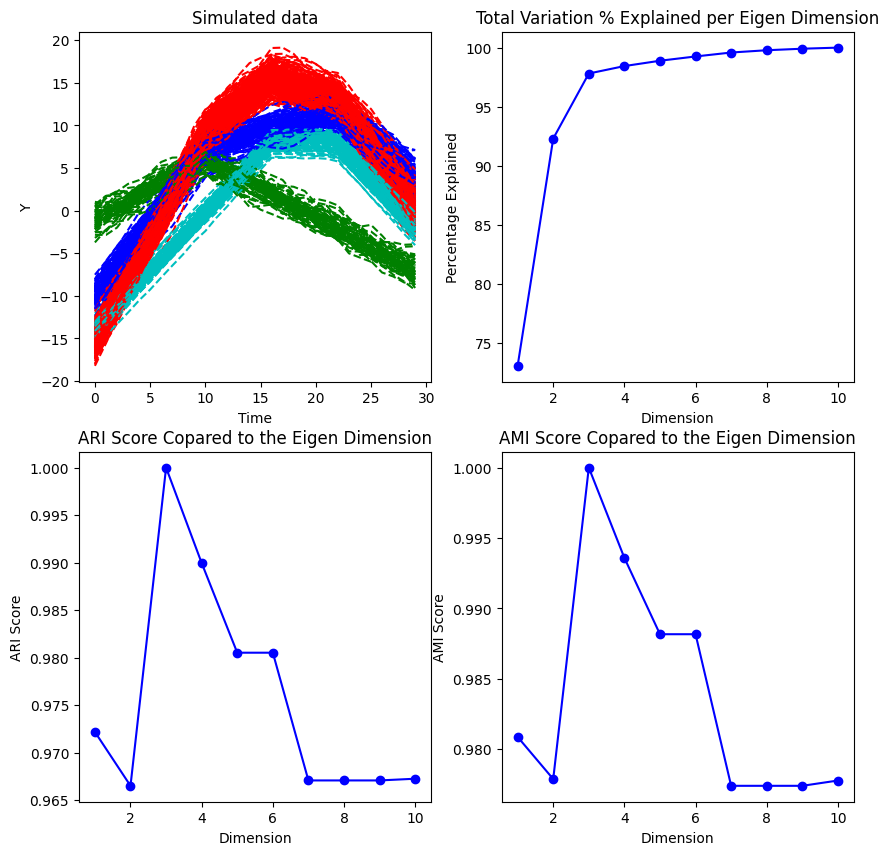

In [113]:
variance, ami, ari, v_range = percentage_variation_ami_ari(10, Y, 150, simulation_label, 4)
plot_percentage_variation_ami_ari(variance, ami, ari, v_range, simulation_label, Y)

In [114]:
# Determine the Eigen Dimension that explains 95% of the variance
for i in range(len(variance)):
    if sum(variance[:i]) >= 0.95:
        print('The Eigen Dimension that explains 95% of the variance is ' + str(i))
        V = i -1
        if V == 0:
            V = 1
        break

The Eigen Dimension that explains 95% of the variance is 3


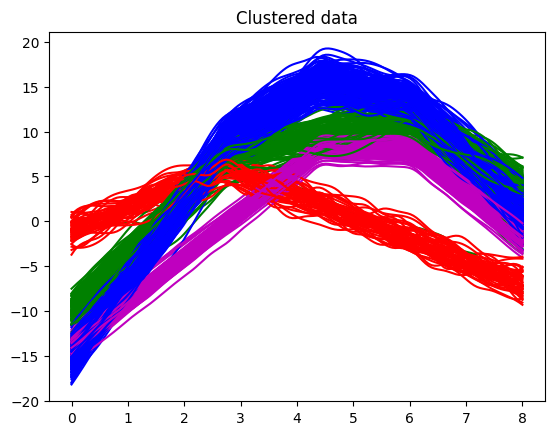

AMI score:
0.9434216635470134
ARI score:
0.9526419416126138


In [115]:
# Get data from the first function
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (Y, V, 150)

# Get data from the second function
membership_matrices, labels = functional_data_clustering (principal_componenets, 4)

# Plot the curves with their labels
t = np.expand_dims(np.linspace(0, 8, len(data_smooth[0])), 1)
for i in range(len(data_smooth)):
    if labels[i] == 0:
        plt.plot(t, data_smooth[i], '-m')
    elif labels[i] == 1:
        plt.plot(t, data_smooth[i], '-g')
    elif labels[i] == 2:
        plt.plot(t, data_smooth[i], '-b')
    else:
        plt.plot(t, data_smooth[i], '-r')
plt.title('Clustered data')
plt.show()

# Get the AMI score
print("AMI score:")
print(adjusted_mutual_info_score(simulation_label, labels))

# Get the ARM scoree
print("ARI score:")
print(adjusted_rand_score(simulation_label, labels))

FCUBT Method Test

In [116]:
from FDApy.clustering.fcubt import Node, FCUBT
from FDApy.representation.functional_data import DenseFunctionalData

# Make t a dict
t = np.expand_dims(np.linspace(0, 20, len(Y[0])), 1)
t = {'input_dim_0': t}
# Change t from (100, 1) to (100,)
t = {k: v.squeeze() for k, v in t.items()}

data = DenseFunctionalData(t, Y)
# Build the tree
root_node = Node(data, is_root=True)
fcubt = FCUBT(root_node=root_node)

# Growing
fcubt.grow(n_components=0.95, min_size=10)

# Joining
fcubt.join(n_components=0.95)

# Get the ARI
print("ARI score: %f" % adjusted_rand_score(simulation_label, fcubt.labels_join))
# Get the AMI
print("AMI score: %f" % adjusted_mutual_info_score(simulation_label, fcubt.labels_join))


ARI score: 1.000000
AMI score: 1.000000


In [117]:
# Store the data in DataStore.csv
np.savetxt('Data/DataStore.csv', Y, delimiter=',')

In [118]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.2.2" # change as needed

%reload_ext rpy2.ipython

In [119]:
# Perform FunHDDC on the data

# Load packages
%R library(fda)
%R library(funHDDC)
%R library(mclust)
%R library(tidyverse)

# # Load data
%R argvals <- seq(0, 1, length.out = 30)
%R values <- t(as.matrix(read.csv('~/ProjectDocs/Project_code/simuations/Data/DataStore.csv', header = FALSE))) # nolint

# FunHDDC
%R basis <- create.bspline.basis(rangeval = c(min(argvals), max(argvals)), nbasis = 25, norder = 3) # nolint

%R data_fd <- smooth.basis(argvals = argvals, y = values, fdParobj = basis)$fd
%R res_clust <- funHDDC(data_fd, K = 4, threshold = 0.3, model = 'ABQkDk', itermax = 2000, eps = 1e-3, init = 'kmeans') # nolint
%R pred_labels <- res_clust$class

%R print(pred_labels)

# Write the pred_labels to a file
%R write.csv(pred_labels, file = '~/ProjectDocs/Project_code/simuations/Data/PredictedLabelsStore.csv') # nolint

   model K threshold complexity           BIC
1 ABQKDK 4       0.3        357 -3,607,312.13

SELECTED: model  ABQKDK  with  4  clusters.
Selection Criterion: BIC.
  [1] 1 2 3 3 2 3 3 3 3 3 2 4 1 3 2 3 2 3 4 4 4 4 1 4 1 4 2 2 4 2 4 3 3 3 2 1 3
 [38] 4 3 3 4 1 1 2 2 4 1 4 3 3 1 4 4 3 1 4 3 4 2 1 1 1 1 2 3 1 1 1 2 3 4 1 2 4
 [75] 1 4 2 1 1 4 1 3 2 2 4 4 4 2 2 4 3 3 2 4 2 3 3 3 3 2 1 4 3 1 1 4 3 1 3 1 3
[112] 1 1 3 2 2 2 1 2 4 3 4 1 4 2 1 4 2 2 1 1 2 1 1 1 4 1 3 2 2 4 3 3 3 2 2 3 1
[149] 3 4 4 2 3 2 3 4 1 2 3 3 3 4 2 3 3 3 1 2 4 1 2 4 1 3 3 3 3 3 2 3 3 4 2 2 3
[186] 4 1 3 1 2 1 4 4 1 3 1 4 4 1 1 4 4 1 1 1 1 3 1 1 4 1 3 4 1 3 3 3 2 1 2 3 3
[223] 4 1 1 2 4 3 1 1 2 2 4 1 1 1 1 4 1 1 3 3 2 3 1 3 2 1 3 3 3 3 2 3 1 1 4 2 2
[260] 1 3 1 1 1 1 2 3 1 2 2 1 3 1 4 4 3 4 4 1 4 1 3 1 1 2 4 4 4 2 3 1 4 2 3 4 4
[297] 3 2 2 4 4 1 4 3 2 2 3 1 3 1 2 2 1 3 1 3 3 4 2 1 4 1 4 1 4 3 2 2 3 4 4 3 1
[334] 1 2 2 2 1 4 1 3 1 1 4 2 1 2 3 3 2 2 3 4 1 3 1 2 2 4 1 1 3 1 1 1 3 2 2 2 1
[371] 3 1 4 3 1 4 2 2 3 1 1 4 2 2 3 4

In [120]:
# To simulate funHDDC, run run the R file funHDDC.R

# Read Labels from PredictedLabels.csv, ignoring the header and the first column
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=1)
print("ARI score for funHDDC: %f" % adjusted_rand_score(simulation_label, predicted_labels))
print("AMI score for funHDDC: %f" % adjusted_mutual_info_score(simulation_label, predicted_labels))

ARI score for funHDDC: 0.613775
AMI score for funHDDC: 0.794176


In [121]:
# Load packages
%R library(fda)
%R library(funFEM)
%R library(mclust)
%R library(tidyverse)

# Load data
%R argvals <- seq(0, 1, length.out = 30)
%R values <- t(as.matrix(read.csv('~/ProjectDocs/Project_code/simuations/Data/DataStore.csv', header = FALSE))) # nolint

# FunHDDC
%R basis <- create.bspline.basis(rangeval = c(min(argvals), max(argvals)), nbasis = 25, norder = 3) # nolint
%R data_fd <- smooth.basis(argvals = argvals, y = values, fdParobj = basis)$fd
%R res_clust = funFEM(data_fd,K=4) # nolint # nolint: commas_linter.
%R pred_labels <- res_clust$P

%R print(pred_labels)

# Write the pred_labels to a file
%R write.csv(pred_labels, file = '~/ProjectDocs/Project_code/simuations/Data/PredictedLabelsStore.csv') # nolint


       [,1] [,2] [,3] [,4]
  [1,]    1    0    0    0
  [2,]    1    0    0    0
  [3,]    1    0    0    0
  [4,]    1    0    0    0
  [5,]    1    0    0    0
  [6,]    1    0    0    0
  [7,]    1    0    0    0
  [8,]    1    0    0    0
  [9,]    1    0    0    0
 [10,]    1    0    0    0
 [11,]    1    0    0    0
 [12,]    1    0    0    0
 [13,]    1    0    0    0
 [14,]    1    0    0    0
 [15,]    1    0    0    0
 [16,]    1    0    0    0
 [17,]    1    0    0    0
 [18,]    1    0    0    0
 [19,]    1    0    0    0
 [20,]    1    0    0    0
 [21,]    1    0    0    0
 [22,]    1    0    0    0
 [23,]    1    0    0    0
 [24,]    1    0    0    0
 [25,]    1    0    0    0
 [26,]    1    0    0    0
 [27,]    1    0    0    0
 [28,]    1    0    0    0
 [29,]    1    0    0    0
 [30,]    1    0    0    0
 [31,]    1    0    0    0
 [32,]    1    0    0    0
 [33,]    1    0    0    0
 [34,]    1    0    0    0
 [35,]    1    0    0    0
 [36,]    0    0    0    1
 

In [122]:
# Read labels from PredictedLabels.csv, ignoring the header and the first column and getting the first four columns
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=range(1, 5))
# Format the labels
labels = np.zeros(len(predicted_labels))
for i in range(len(predicted_labels)):
    labels[i] = np.argmax(predicted_labels[i])
print("ARI score for funFEM: %f" % adjusted_rand_score(simulation_label, labels))
print("AMI score for funFEM: %f" % adjusted_mutual_info_score(simulation_label, labels))

ARI score for funFEM: 0.200964
AMI score for funFEM: 0.399970
